# Import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, resample, find_peaks
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")

## Support Vector Machine

In [24]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

In [25]:
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'decision_function_shape': ['ovr', 'ovo']
}

# Create an SVM classifier
svm_classifier = SVC(random_state=100)

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='recall_weighted')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Make predictions on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate the accuracy, recall, precision, and F1-score of the classifier
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1:", f1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Best Parameters: {'C': 100, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Accuracy: 0.21242576518958428
Recall: 0.21242576518958428
Precision: 0.7522923101180697
F1: 0.24308613525231365
Confusion matrix:
 [[   57    86    19     1     2]
 [ 1660  2772 12984   111   561]
 [   24    19  1593     2     1]
 [   89    56   334    14    64]
 [  154   226   843     4   214]]


## Neural Network Model

In [26]:
# Read processed_df.csv
processed_df = pd.read_csv('dataframes/processed_df.csv')

{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}
26/26 [==============================] - 0s 1ms/step
0.5205479452054794
0.4916246531045094
0.5205479452054794
26/26 [==============================] - 0s 1ms/step
0.5628891656288917
0.5436452498896717
0.5628891656288917
26/26 [==============================] - 0s 1ms/step
0.572851805728518
0.5460237842698068
0.572851805728518
26/26 [==============================] - 0s 1ms/step
0.5778331257783312
0.5501711341458048
0.5778331257783312
26/26 [==============================] - 0s 1ms/step
0.5815691158156912
0.5658955757083954
0.5815691158156912
Mean Accuracy: 56.3%
Mean F1 Score: 53.9%
Mean Recall: 56.3%


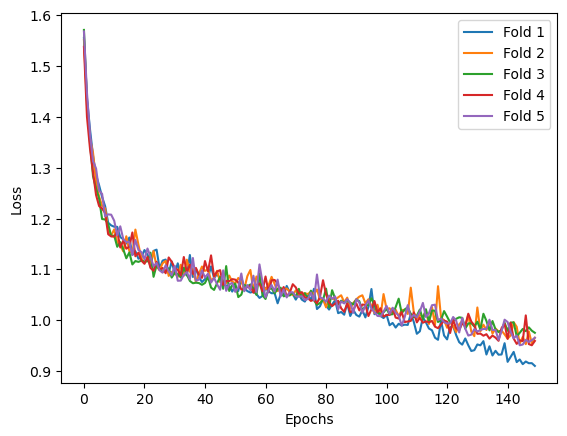

In [27]:
target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 1 median', 'Signal 1 mean absolute deviation', 'Signal 1 quantile 25', 'Signal 1 quantile 75', 'Signal 1 iqr', 'Signal 1 peak', 'Signal 1 valley', 'Signal 1 skewness', 'Signal 1 kurtosis', 'Signal 1 entropy', 'Signal 1 psd entropy', 'Signal 1 psd dominant frequency', 'Signal 1 psd dominant magnitude', 
                                     'Signal 2 mean', 'Signal 2 std', 'Signal 2 median', 'Signal 2 mean absolute deviation', 'Signal 2 quantile 25', 'Signal 2 quantile 75', 'Signal 2 iqr', 'Signal 2 peak', 'Signal 2 valley', 'Signal 2 skewness', 'Signal 2 kurtosis', 'Signal 2 entropy', 'Signal 2 psd entropy', 'Signal 2 psd dominant frequency', 'Signal 2 psd dominant magnitude']

# Encode the target variable into numerical values
le = LabelEncoder()
processed_df[target_column] = le.fit_transform(processed_df[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Define the number of cross-validation folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores and histories
cv_accuracy = []
cv_f1 = []
cv_recall = []
histories = []

# Define the architecture of the deep neural network
def create_model(input_dim, num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(processed_df[other_column_names], processed_df[target_column]):
    X_train, X_test = processed_df[other_column_names].iloc[train_index], processed_df[other_column_names].iloc[test_index]
    y_train, y_test = processed_df[target_column].iloc[train_index], processed_df[target_column].iloc[test_index]

    # Create and compile the model
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = create_model(input_dim, num_classes)

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    histories.append(history.history)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_f1 = f1_score(y_test, y_pred, average='weighted')
    fold_recall = recall_score(y_test, y_pred, average='weighted')

    print(fold_accuracy)
    print(fold_f1)
    print(fold_recall)

    cv_accuracy.append(fold_accuracy)
    cv_f1.append(fold_f1)
    cv_recall.append(fold_recall)

    # Print confusion matrix for this fold
    #print(confusion_matrix(y_test, y_pred))

# Calculate the mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(cv_accuracy)
std_accuracy = np.std(cv_accuracy)
mean_f1 = np.mean(cv_f1)
std_f1 = np.std(cv_f1)
mean_recall = np.mean(cv_recall)
std_recall = np.std(cv_recall)

print(f"Mean Accuracy: {mean_accuracy*100:.1f}%")
print(f"Mean F1 Score: {mean_f1*100:.1f}%")
print(f"Mean Recall: {mean_recall*100:.1f}%")

# Plot the loss for each fold
for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i + 1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Neural Network Model using train_df and test_df

In [28]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}
Epoch 1/150
100/100 [==============================] - 2s 10ms/step - loss: 1.5535 - accuracy: 0.2819 - val_loss: 1.6239 - val_accuracy: 0.0530
Epoch 2/150
100/100 [==============================] - 1s 9ms/step - loss: 1.4178 - accuracy: 0.3769 - val_loss: 1.4763 - val_accuracy: 0.2884
Epoch 3/150
100/100 [==============================] - 1s 9ms/step - loss: 1.3357 - accuracy: 0.4331 - val_loss: 1.5985 - val_accuracy: 0.0587
Epoch 4/150
100/100 [==============================] - 1s 8ms/step - loss: 1.2763 - accuracy: 0.4773 - val_loss: 1.3615 - val_accuracy: 0.3664
Epoch 5/150
100/100 [==============================] - 1s 8ms/step - loss: 1.2428 - accuracy: 0.4835 - val_loss: 1.4372 - val_accuracy: 0.2467
Epoch 6/150
100/100 [==============================] - 1s 9ms/step - loss: 1.2060 - accuracy: 0.5071 - val_loss: 1.5195 - val_accuracy: 0.2806
Epoch 7/150
100/100 [==============================] - 1s 8ms/step - loss: 1.2068 - accuracy: 0.5165

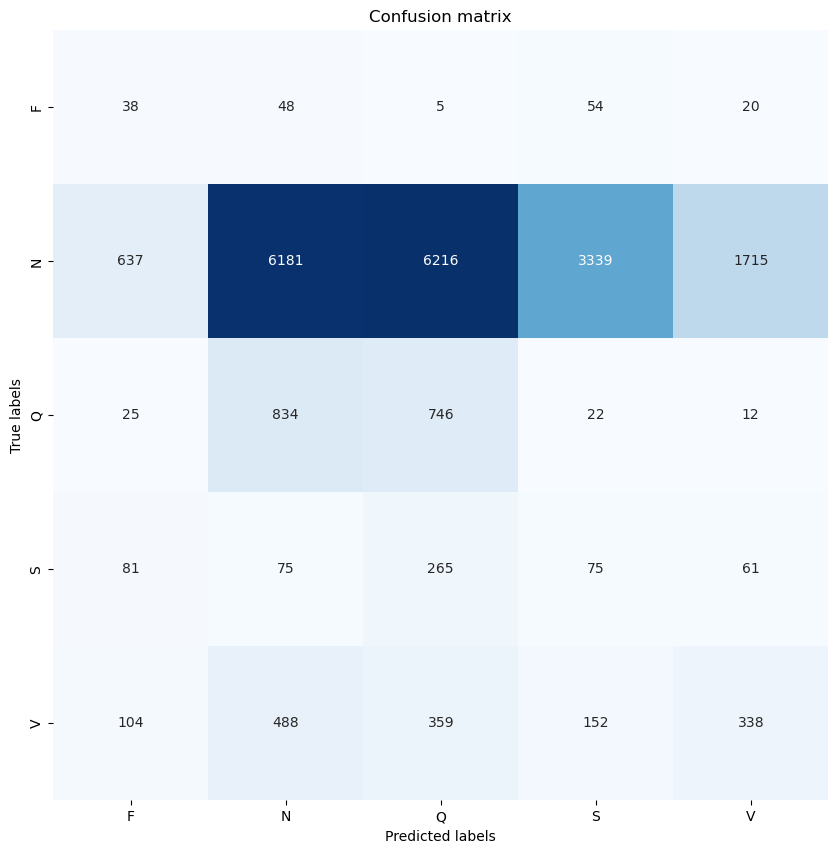

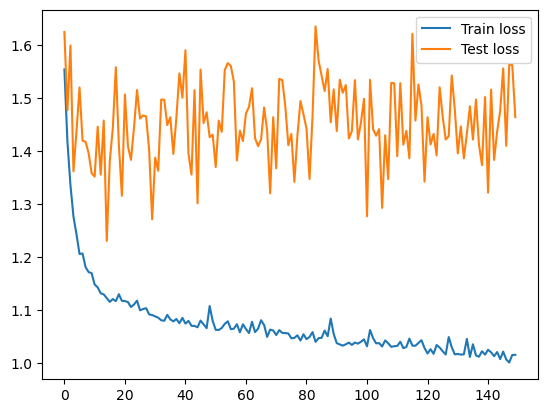

In [29]:
input_dim = train_df.shape[1] - 1

# Create and compile the Sequential model
model = keras.Sequential()
model.add(layers.Input(shape=(input_dim,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

target_column = 'Type'
# Other column names should exclude the target column
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Fit the model to your training data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)  

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.1f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1*100:.1f}%')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall*100:.1f}%')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision*100:.1f}%')

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(0.5, num_classes), le.classes_)
plt.yticks(np.arange(0.5, num_classes), le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# Plot train and test loss on the same figure
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Test loss'])
plt.show()


In [30]:
# Print the count of each predicted class
print(pd.Series(y_pred).value_counts())

# Print the count of each actual class
print(pd.Series(y_test).value_counts())

cm = confusion_matrix(y_test, y_pred)
print(cm)

1    7626
2    7591
3    3642
4    2146
0     885
dtype: int64
1    18088
2     1639
4     1441
3      557
0      165
Name: Type, dtype: int64
[[  38   48    5   54   20]
 [ 637 6181 6216 3339 1715]
 [  25  834  746   22   12]
 [  81   75  265   75   61]
 [ 104  488  359  152  338]]


## Balanced processed_df Convolutional Neural Network

26/26 [==============================] - 0s 1ms/step
0.44831880448318806
0.4433747030692202
0.44831880448318806
26/26 [==============================] - 0s 1ms/step
0.47073474470734744
0.45794106134144
0.47073474470734744
26/26 [==============================] - 0s 1ms/step
0.41469489414694893
0.411286168471275
0.41469489414694893
26/26 [==============================] - 0s 1ms/step
0.43711083437110837
0.4313591728028356
0.43711083437110837
26/26 [==============================] - 0s 1ms/step
0.4520547945205479
0.4448501522612627
0.4520547945205479
Mean Accuracy: 44.5%
Mean F1 Score: 43.8%
Mean Recall: 44.5%


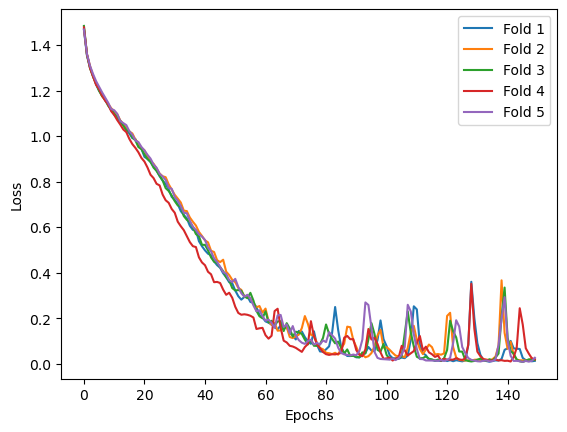

In [31]:
# Assuming you have your dataset loaded into a DataFrame called 'processed_df'
target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 1 median', 'Signal 1 mean absolute deviation', 'Signal 1 quantile 25', 'Signal 1 quantile 75', 'Signal 1 iqr', 'Signal 1 peak', 'Signal 1 valley', 'Signal 1 skewness', 'Signal 1 kurtosis', 'Signal 1 entropy', 'Signal 1 psd entropy', 'Signal 1 psd dominant frequency', 'Signal 1 psd dominant magnitude', 'Signal 2 mean', 'Signal 2 std', 'Signal 2 median', 'Signal 2 mean absolute deviation', 'Signal 2 quantile 25', 'Signal 2 quantile 75', 'Signal 2 iqr', 'Signal 2 peak', 'Signal 2 valley', 'Signal 2 skewness', 'Signal 2 kurtosis', 'Signal 2 entropy', 'Signal 2 psd entropy', 'Signal 2 psd dominant frequency', 'Signal 2 psd dominant magnitude']

# Encode the target variable into numerical values
le = LabelEncoder()
processed_df[target_column] = le.fit_transform(processed_df[target_column])

# Define the number of cross-validation folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores and histories
cv_accuracy = []
cv_f1 = []
cv_recall = []
histories = []

# Define the architecture of the CNN
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(processed_df[other_column_names], processed_df[target_column]):
    X_train, X_test = processed_df[other_column_names].iloc[train_index], processed_df[other_column_names].iloc[test_index]
    y_train, y_test = processed_df[target_column].iloc[train_index], processed_df[target_column].iloc[test_index]

    # Scale the input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create and compile the CNN model
    input_shape = (len(other_column_names), 1)  # Input shape matches the number of columns in other_column_names
    num_classes = len(np.unique(y_train))
    model = create_cnn_model(input_shape, num_classes)

    # Reshape the input data to match the CNN architecture
    X_train = X_train.reshape(-1, len(other_column_names), 1)
    X_test = X_test.reshape(-1, len(other_column_names), 1)

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    histories.append(history.history)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_f1 = f1_score(y_test, y_pred, average='weighted')
    fold_recall = recall_score(y_test, y_pred, average='weighted')

    print(fold_accuracy)
    print(fold_f1)
    print(fold_recall)

    cv_accuracy.append(fold_accuracy)
    cv_f1.append(fold_f1)
    cv_recall.append(fold_recall)

# Calculate the mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(cv_accuracy)
std_accuracy = np.std(cv_accuracy)
mean_f1 = np.mean(cv_f1)
std_f1 = np.std(cv_f1)
mean_recall = np.mean(cv_recall)
std_recall = np.std(cv_recall)

print(f"Mean Accuracy: {mean_accuracy*100:.1f}%")
print(f"Mean F1 Score: {mean_f1*100:.1f}%")
print(f"Mean Recall: {mean_recall*100:.1f}%")

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i + 1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Unbalanced test_df Convolutional Neural Network

685/685 [==============================] - 1s 1ms/step
[[  16   32   42   69    6]
 [ 479 5878 4137 1932 5662]
 [  22 1092   33   17  475]
 [  73  239   42  103  100]
 [  80  410  183  135  633]]
Accuracy: 30.4%
F1 Score: 39.0%
Recall: 30.4%
Precision: 64.3%


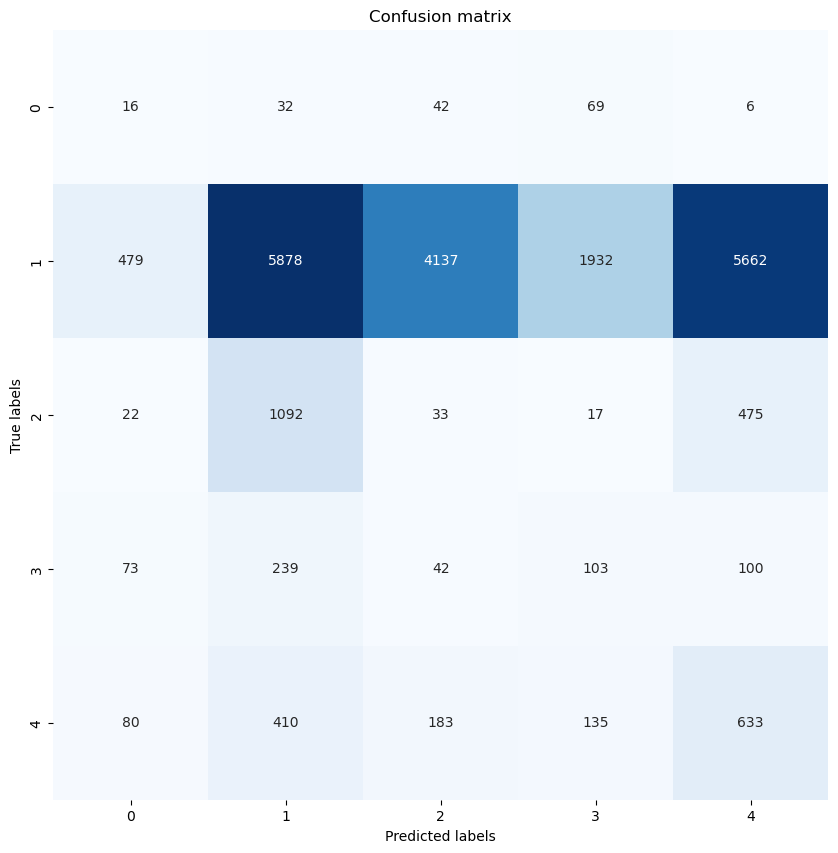

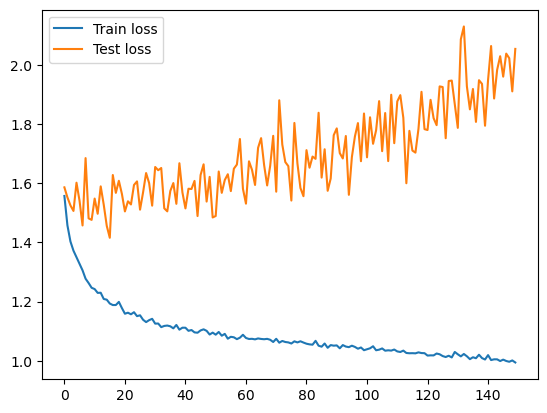

In [32]:
# Your target column and other column names
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.transform(test_df[target_column])

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Reshape data for CNN (1D Convolutional Neural Network)
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and compile the CNN model
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model to your training data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, verbose=0)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.1f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1*100:.1f}%')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall*100:.1f}%')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision*100:.1f}%')

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(0.5, len(np.unique(y_test)), 1), le.classes_)
plt.yticks(np.arange(0.5, len(np.unique(y_test)), 1), le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# Plot train and test loss on the same figure
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Test loss'])
plt.show()

### Bagging Ensemble method

In [33]:
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

X_train = train_df[other_column_names]
y_train = train_df[target_column]
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Define hyperparameters
n_classes = len(np.unique(y_train))
n_base_models = n_classes  # Number of base models, one for each class
n_estimators = 10
n_epochs = 150
batch_size = 32

# Create a list to store base models
base_models = []

# Train a separate MLP model for each class
for class_label in range(n_classes):

    print(class_label)

    # Create a new MLP model for each class
    model = MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32), max_iter=1000)  # Customize architecture and hyperparameters

    # Convert the multiclass problem into a binary classification problem
    y_train_binary = (y_train == class_label).astype(int)

    # Create a BaggingClassifier for the MLP model
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=n_estimators, random_state=42)

    # Train the BaggingClassifier
    bagging_model.fit(X_train, y_train_binary)

    # Append the trained model to the list of base models
    base_models.append(bagging_model)

# Make predictions on the test data using each base model
predictions = np.array([model.predict(X_test) for model in base_models])

# Aggregate predictions by selecting the class with the highest number of votes
ensemble_predictions = np.argmax(predictions, axis=0)

# Evaluate the ensemble's performance
ensemble_accuracy = accuracy_score(y_test.to_numpy(), ensemble_predictions)
ensemble_recall = recall_score(y_test.to_numpy(), ensemble_predictions, average='weighted')
ensemble_precision = precision_score(y_test.to_numpy(), ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(y_test.to_numpy(), ensemble_predictions, average='weighted')
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Recall: {ensemble_recall:.4f}")
print(f"Ensemble Precision: {ensemble_precision:.4f}")
print(f"Ensemble F1 Score: {ensemble_f1:.4f}")

0
1
2
3
4
Ensemble Accuracy: 0.1509
Ensemble Recall: 0.1509
Ensemble Precision: 0.7063
Ensemble F1 Score: 0.2224


In [34]:
# Print the count of each class in the test set
print(f"Class counts in the test set: {np.unique(y_test, return_counts=True)[1]}")
# Print the count of each class in the ensemble's predictions
print(f"Class counts in the ensemble's predictions: {np.unique(ensemble_predictions, return_counts=True)[1]}")

Class counts in the test set: [  165 18088  1639   557  1441]
Class counts in the ensemble's predictions: [13734  3067  2611   662  1816]


### 1 vs all ensemble method

In [35]:
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

X_train = train_df[other_column_names]
y_train = train_df[target_column]
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Define hyperparameters
n_classes = len(np.unique(y_train))
n_base_models = n_classes  # Number of base models, one for each class
n_epochs = 150
batch_size = 32

# Create a list to store base models
base_models = []

# Train a separate model for each class
for class_label in range(n_classes):
    # Create a new model for each class
    model = keras.Sequential()
    model.add(keras.layers.Dense(32, activation='relu', input_dim=X_train.shape[1]))
    model.add(keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

    # If y is equal to class_label, set y_train_binary to 1, otherwise set it to 0
    y_train_binary = np.where(y_train == class_label, 1, 0)
    y_test_binary = np.where(y_test == class_label, 1, 0)

    # Train the model for binary classification
    model.fit(X_train, y_train_binary, epochs=n_epochs, batch_size=batch_size, verbose=0)

    # Append the trained model to the list of base models
    base_models.append(model)

# Make predictions on the test data using each base model
predictions = np.array([model.predict(X_test) for model in base_models])

# # Select the index of the highest probability from the predictions
ensemble_predictions = np.argmax(predictions, axis=0)

# Evaluate the ensemble's performance
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
ensemble_recall = recall_score(y_test, ensemble_predictions, average='weighted')
print(f"Ensemble Recall: {ensemble_recall:.4f}")
ensemble_precision = precision_score(y_test, ensemble_predictions, average='weighted')
print(f"Ensemble Precision: {ensemble_precision:.4f}")
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='weighted')
print(f"Ensemble F1 Score: {ensemble_f1:.4f}")

685/685 [==============================] - 1s 1ms/step
Ensemble Accuracy: 0.3690
Ensemble Recall: 0.3690
Ensemble Precision: 0.6991
Ensemble F1 Score: 0.4624
